In [10]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def reduce_to_first_order(f_expr, order):
    """
    Reduces an nth-order ODE to a system of first-order ODEs.

    Parameters:
        f_expr : sympy expression for the nth-order ODE
        order  : the order of the ODE (e.g., 2 for y'')

    Returns:
        f_func  : a function representing the system of first-order ODEs
        Y_symbols : list of first-order variables [y, y', ..., y^(n-1)]
    """
    # Create symbols Y0, Y1, ..., Y_{order-1} representing y, y', ..., y^(n-1)
    Y_symbols = sp.symbols(' '.join([f'Y{i}' for i in range(order)]), seq=True)

    # Build a substitution map: y(x)->Y0, y'(x)->Y1, ..., y^(n-1)(x)->Y_{n-1}
    subs_map = {sp.Function('y')(x): Y_symbols[0]}
    for i in range(1, order):
        subs_map[sp.Derivative(sp.Function('y')(x), x, i)] = Y_symbols[i]

    # Substitute into the ODE to express the highest derivative in terms of Y_symbols
    f_sub = f_expr.subs(subs_map)

    # Lambdify to generate the function for numerical evaluation
    f_func = sp.lambdify((x,) + Y_symbols, f_sub, 'numpy')

    return f_func, Y_symbols

def f_system(x_val, y_vals, order, f_func):
    """
    Return the derivatives [y0', y1', ..., y_{n-1}'] for the system of first-order ODEs.

    Parameters:
        x_val : current x value
        y_vals : list of current values [y0, y1, ..., y_{n-1}]
        order : the order of the ODE
        f_func : the lambda function for the system of ODEs

    Returns:
        derivs : array of derivatives [y0', y1', ..., y_{n-1}']
    """
    derivs = np.zeros(order)

    # y0' = y1, y1' = y2, ..., y_{n-2}' = y_{n-1}
    for i in range(order-1):
        derivs[i] = y_vals[i+1]

    # Last equation: y_{n-1}' = f(x, y0, ..., y_{n-1})
    derivs[order-1] = f_func(x_val, *y_vals)

    return derivs

def runge_kutta(f_func, order, x0, initial_conditions, h, x_end):
    """
    Solve the system of first-order ODEs using the 4th-order Runge-Kutta method.

    Parameters:
        f_func : function that returns the system of derivatives
        order : the order of the ODE (e.g., 2 for y'')
        x0 : initial x value
        initial_conditions : initial values for y(0), y'(0), ..., y^(n-1)(0)
        h : step size
        x_end : end value of x

    Returns:
        xs : array of x values
        ys : array of solution values for each step
    """
    N_steps = int((x_end - x0) / h)  # number of RK4 steps
    xs = np.zeros(N_steps + 1)
    ys = np.zeros((order, N_steps + 1))

    xs[0] = x0
    ys[:, 0] = initial_conditions

    # RK4 loop
    for i in range(N_steps):
        x_curr = xs[i]
        y_curr = ys[:, i]

        # Compute RK4 slopes k1..k4 using the system function
        k1 = f_system(x_curr, y_curr, order, f_func)
        k2 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k1, order, f_func)
        k3 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k2, order, f_func)
        k4 = f_system(x_curr + h,     y_curr + h*k3, order, f_func)

        # Update solution for next step
        ys[:, i+1] = y_curr + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        xs[i+1] = x_curr + h

    return xs, ys

In [ ]:
# --- Example usage for a 2nd, 3rd, or 4th order ODE ---

# Define the symbolic independent variable and function
x = sp.symbols('x')
y = sp.Function('y')

# Example ODE: y'' = -y (simple harmonic oscillator)
order = 2  # Choose order: 2 for y'', 3 for y''', 4 for y'''' etc.

# Define the ODE (e.g., y'' = -y)
if order == 2:
    f_expr = -y(x)  # y'' = -y
elif order == 3:
    f_expr = -y(x) - y(x).diff(x)  # y''' = -y - y'
elif order == 4:
    f_expr = -y(x) - y(x).diff(x, 2)  # y'''' = -y - y''
else:
    raise ValueError("Order not supported. Use 2, 3, or 4.")

# Initial conditions: [y(0), y'(0), y''(0), y'''(0)] for respective orders
initial_conditions = [0.0, 1.0] if order == 2 else [0.0, 1.0, 0.0] if order == 3 else [0.0, 1.0, 0.0, 0.0]

# Reduce the ODE to a system of first-order ODEs
f_func, Y_symbols = reduce_to_first_order(f_expr, order)

# Integration parameters
x0 = 0.0  # initial x value
h = 0.1   # step size
x_end = 1.0  # end x value

# Solve the system
runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([[0.        , 0.09983333, 0.19866917, 0.29551996, 0.38941803,
         0.47942516, 0.56464204, 0.64421721, 0.71735559, 0.7833264 ,
         0.84147048],
        [1.        , 0.99500417, 0.9800666 , 0.95533654, 0.9210611 ,
         0.87758273, 0.82533586, 0.76484252, 0.69670715, 0.62161051,
         0.54030297]]))

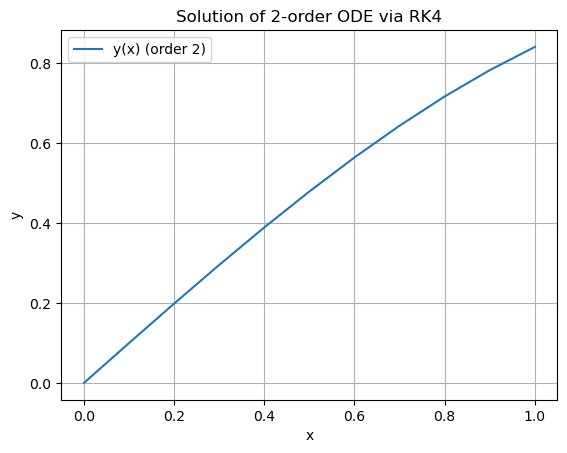

In [ ]:
xs, ys = runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

# --- Plot the solution ---
plt.plot(xs, ys[0], label=f'y(x) (order {order})')  # Plot y(x) for order 2, 3, or 4
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Solution of {order}-order ODE via RK4')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def estimate_rk4_error(f_func, order, x0, y0, h, x_end):
    """
    Estimate the global error for any order IVP using RK4 and Richardson Extrapolation.

    Parameters:
        f_func: RHS function from reduced first-order system.
        order: Order of the original ODE (int).
        x0: Initial value of x.
        y0: List of initial values [y, y', ..., y^{n-1}].
        h: Step size.
        x_end: Final x value.

    Returns:
        xs: x-values grid
        y0_values: Solution for the primary function y(x)
        error_estimates: Estimated global error for y(x)
    """
    # Get RK4 solution with step size h
    xs_h, ys_h = runge_kutta(f_func, order, x0, y0, h, x_end)

    # Get RK4 solution with step size h/2 (more accurate)
    xs_h2, ys_h2 = runge_kutta(f_func, order, x0, y0, h/2, x_end)

    # Align both solutions: pick every second point from h/2 solution
    aligned_ys_h2 = ys_h2[:, ::2]  # Matches same x-grid as xs_h

    # Estimate error using only the y0 component (the function itself, not derivatives)
    y0_h = ys_h[0]         # y at step h
    y0_h2 = aligned_ys_h2[0]  # y at step h/2 (downsampled)

    # Richardson extrapolation formula for RK4: error ≈ (y_h2 - y_h) / (2^4 - 1)
    error = np.abs(y0_h2 - y0_h) / 15.0

    return xs_h, y0_h, error


In [ ]:
xs, y_vals, error = estimate_rk4_error(f_func, order, x0, initial_conditions, h, x_end)

# Print result
for xi, yi, ei in zip(xs, y_vals, error):
    print(f"x = {xi:.2f}, y ≈ {yi:.6f}, error ≈ {ei:.2e}")

x = 0.00, y ≈ 0.000000, error ≈ 0.00e+00
x = 0.10, y ≈ 0.099833, error ≈ 5.21e-09
x = 0.20, y ≈ 0.198669, error ≈ 1.03e-08
x = 0.30, y ≈ 0.295520, error ≈ 1.53e-08
x = 0.40, y ≈ 0.389418, error ≈ 1.98e-08
x = 0.50, y ≈ 0.479425, error ≈ 2.38e-08
x = 0.60, y ≈ 0.564642, error ≈ 2.72e-08
x = 0.70, y ≈ 0.644217, error ≈ 2.98e-08
x = 0.80, y ≈ 0.717356, error ≈ 3.15e-08
x = 0.90, y ≈ 0.783326, error ≈ 3.22e-08
x = 1.00, y ≈ 0.841470, error ≈ 3.18e-08


In [4]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def solve_ode_particular(f_expr, order, y_var='y', x_var='x', initial_conditions=None):
    """
    Solves the particular solution of an ODE as a SymPy expression.

    Parameters:
        f_epr_expr: SymPy expression for the highest-order derivative, e.g., -y(x) for y'' = -y
        order (int): The order of the ODE (e.g., 2 for y'')
        y_var (str): The dependent variable (default: 'y')
        x_var (str): The independent variable (default: 'x')
        initial_conditions (list): Initial conditions [y(0), y'(0), ..., y^(n-1)(0)]

    Returns:
        SymPy expression for the particular solution.
    """
    x = sp.symbols(x_var)
    y = sp.Function(y_var)(x)

    # Form the ODE: highest-order derivative = f_epr_expr
    eq = sp.Eq(y.diff(x, order), f_epr)

    # Solve the ODE
    if initial_conditions:
        if len(initial_conditions) != order:
            raise ValueError(f"Initial conditions must be a list of length {order}.")
        # Convert list to SymPy initial conditions: y(0)=..., y'(0)=..., etc.
        ics = {y.subs(x, 0): initial_conditions[0]}
        for i in range(1, order):
            ics[y.diff(x, i).subs(x, 0)] = initial_conditions[i]
        sol = sp.dsolve(eq, y, ics=ics)
    else:
        sol = sp.dsolve(eq, y)

    return sol

In [9]:
x = sp.symbols('x')
y = sp.Function('y')

# Example ODE: choose one based on order
order = 2
f_epr = -y(x) - y(x).diff(x)
initial_conditions = [0.0, 1.0]

# Get the analytical particular solution
sol = solve_ode_particular(f_epr, order, initial_conditions=initial_conditions)
print("Particular Solution:", sol)

Particular Solution: Eq(y(x), 1.15470053837925*exp(-x/2)*sin(sqrt(3)*x/2))


In [11]:
x0 = 0.0  # initial x value
h = 0.1   # step size
x_end = 10.0  # end x value

# Reduce the ODE to a system of first-order ODEs
f_func, Y_symbols = reduce_to_first_order(f_epr, order)

# Solve the system numerically
runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. ]),
 array([[ 0.00000000e+00,  9.50041667e-02,  1.80064168e-01,
          2.55317536e-01,  3.20981961e-01,  3.77345589e-01,
          4.24757584e-01,  4.63618996e-01,  4.94374012e-01,
          5.17501628e-01,  5.33507781e-01,  5.42917976e-01,
          5.46270425e-01,  5.44109721e-01,  5.36981056e-01,
          5.